##### La idea de este ejercicio es tomar 5 datasets de estaciones climaticas chilenas en un periodo, unirlos,  depurarlos y hacer modelos para predecir los valores de una sexta de ellas en funcion de las otras 5



In [1]:
import pandas as pd
import numpy as np
import os
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

random.seed(7)

In [2]:
datos_553 = pd.read_csv("./LACA_blended_custom/TG_STAID000553.csv")
datos_553.head()

SOUID      DATE     TG   Q_TG
0  101182  19761001  -9999      9
1  101182  19761002  -9999      9
2  101182  19761003  -9999      9
3  101182  19761004     33      0
4  101182  19761005     21      0

In [3]:
# Importing and joining CSV in single dataframe 
import pandas as pd

#importing first file as data_553 
data_553 = pd.read_csv("./LACA_blended_custom/TG_STAID000553.csv",names=['SOUID','DATE','TG553','Q_TG'],
                        header=0,parse_dates=['DATE'],index_col=['DATE'],usecols=['DATE','TG553']) 

#routin for add following files
def anexo(merge,newset):
    col_name = 'TG'+newset
    data_new = pd.read_csv("./LACA_blended_custom/TG_STAID000"+newset+".csv",names=['SOUID','DATE',col_name,'Q_TG'],
                        header=0,parse_dates=['DATE'],index_col=['DATE'],usecols=['DATE',col_name])
    
    merge_n=pd.merge(merge,data_new, how='inner', left_index=True, right_index=True)
    return merge_n

#adding files
merge = anexo(data_553,'585')
merge = anexo(merge,'588')
merge = anexo(merge,'595')
merge = anexo(merge,'596')
merge = anexo(merge,'597')
merge.head()

TG553  TG585  TG588  TG595  TG596  TG597
DATE                                                
1976-10-01  -9999  -9999  -9999    183    168    183
1976-10-02  -9999  -9999  -9999    172    172    176
1976-10-03  -9999  -9999  -9999    180    175    176
1976-10-04     33  -9999  -9999    176    182    180
1976-10-05     21  -9999  -9999    183    186    177

In [4]:
#Replace with None cols with -9999
cols = ['TG553','TG588','TG585','TG595','TG596','TG597']
for col in cols:
    merge[col] = merge[col].apply(lambda x: None if x == -9999 else x)
merge.head()

TG553  TG585  TG588  TG595  TG596  TG597
DATE                                                
1976-10-01    NaN    NaN    NaN  183.0  168.0  183.0
1976-10-02    NaN    NaN    NaN  172.0  172.0  176.0
1976-10-03    NaN    NaN    NaN  180.0  175.0  176.0
1976-10-04   33.0    NaN    NaN  176.0  182.0  180.0
1976-10-05   21.0    NaN    NaN  183.0  186.0  177.0

In [5]:
merge.head(10)

TG553  TG585  TG588  TG595  TG596  TG597
DATE                                                
1976-10-01    NaN    NaN    NaN  183.0  168.0  183.0
1976-10-02    NaN    NaN    NaN  172.0  172.0  176.0
1976-10-03    NaN    NaN    NaN  180.0  175.0  176.0
1976-10-04   33.0    NaN    NaN  176.0  182.0  180.0
1976-10-05   21.0    NaN    NaN  183.0  186.0  177.0
1976-10-06   23.0   90.0    NaN  187.0  197.0  175.0
1976-10-07   29.0   82.0    NaN  180.0  192.0  174.0
1976-10-08   25.0   78.0    NaN  180.0  189.0  177.0
1976-10-09   32.0   72.0    NaN  181.0  184.0  179.0
1976-10-10   22.0   86.0    NaN  186.0  187.0  184.0

In [6]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14122 entries, 1976-10-01 to 2015-05-31
Data columns (total 6 columns):
TG553    4620 non-null float64
TG585    7128 non-null float64
TG588    2857 non-null float64
TG595    2742 non-null float64
TG596    5664 non-null float64
TG597    2742 non-null float64
dtypes: float64(6)
memory usage: 772.3 KB


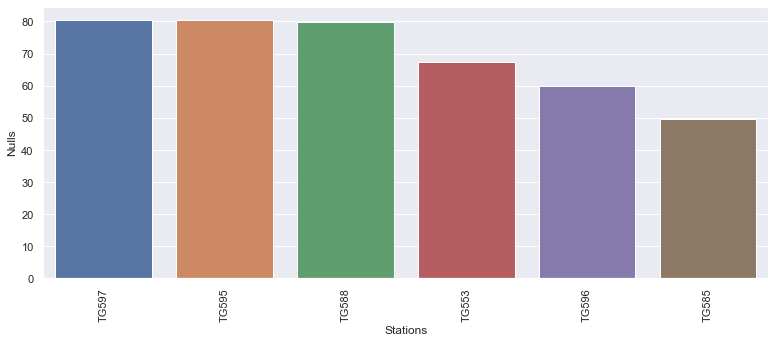

In [7]:
#missing value counts in each of these columns
Isnull = merge.isnull().sum()/len(merge)*100
Isnull = Isnull[Isnull>0]
Isnull.sort_values(inplace=True, ascending=False)
Isnull
Isnull = Isnull.to_frame()
Isnull.columns = ['Nulls']
Isnull.index.names = ['Stations']
Isnull['Stations'] = Isnull.index

#plot Missing values
plt.figure(figsize=(13, 5))
sns.set(style='darkgrid',color_codes=True,)
sns.barplot(x='Stations', y='Nulls', data=Isnull)
plt.xticks(rotation = 90)
plt.show()

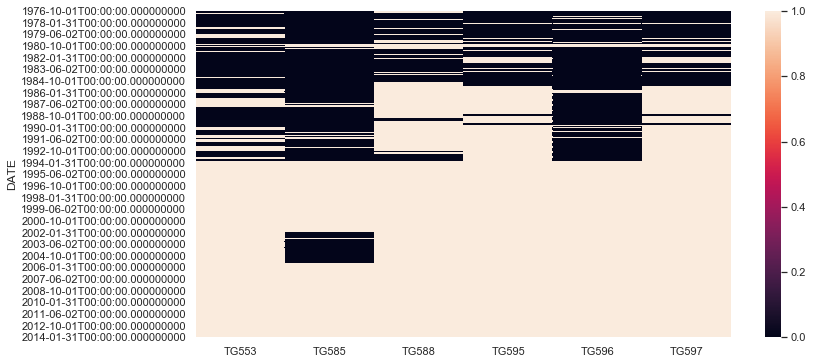

In [8]:
plt.figure(figsize=(12, 6))
sns.heatmap(merge.isnull())
plt.show()

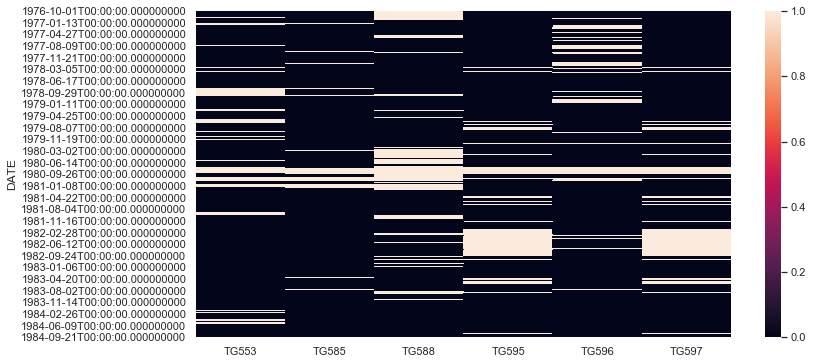

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(merge.loc['1976-10-01':'1984-12-31'].isnull())
plt.show()

In [10]:
merge.dropna(inplace=True)
merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1477 entries, 1976-12-28 to 1984-11-21
Data columns (total 6 columns):
TG553    1477 non-null float64
TG585    1477 non-null float64
TG588    1477 non-null float64
TG595    1477 non-null float64
TG596    1477 non-null float64
TG597    1477 non-null float64
dtypes: float64(6)
memory usage: 80.8 KB


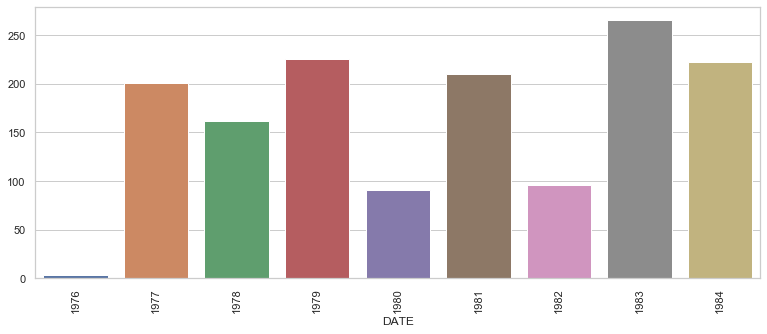

In [11]:
anual = merge.groupby(merge.index.year)
serie = anual.size()

plt.figure(figsize=(13, 5))
sns.set(style='whitegrid')
sns.barplot(x=serie.index, y=serie)
plt.xticks(rotation = 90)
plt.show()


## Empecemos a trabajar con algoritmos de regresion, vamos a hacer una copia del dataset "merge" para dejar intacto el original


In [12]:
#print aca freno

In [13]:
datos = merge.copy()
datos.head(20)


TG553  TG585  TG588  TG595  TG596  TG597
DATE                                                
1976-12-28   30.0  100.0  250.0  260.0  236.0  237.0
1976-12-29   55.0  101.0  246.0  248.0  239.0  239.0
1976-12-30   53.0   99.0  253.0  230.0  249.0  242.0
1976-12-31   70.0  105.0  248.0  229.0  241.0  236.0
1977-01-01   55.0  111.0  245.0  227.0  238.0  239.0
1977-01-02   46.0  101.0  256.0  234.0  250.0  240.0
1977-01-05   71.0  102.0  234.0  217.0  229.0  216.0
1977-01-06   80.0  120.0  243.0  228.0  227.0  229.0
1977-01-07   51.0  138.0  254.0  235.0  243.0  250.0
1977-01-08   47.0  121.0  243.0  227.0  246.0  240.0
1977-01-09   58.0   89.0  256.0  237.0  250.0  257.0
1977-01-10   61.0   90.0  255.0  253.0  257.0  250.0
1977-01-11   38.0   71.0  248.0  249.0  255.0  242.0
1977-01-12   49.0   72.0  244.0  242.0  249.0  241.0
1977-01-13   36.0   78.0  243.0  242.0  246.0  237.0
1977-01-14   63.0   72.0  247.0  243.0  246.0  246.0
1977-01-15   32.0   88.0  256.0  252.0  253.0  251.0
1977-01-16   52.0   97.0  254.0  250.0  257.0  250.0
1977-01-17   55.0  105.0  261.0  245.0  243.0  257.0
1977-01-18   44.0   90.0  264.0  241.0  244.0  254.0

In [14]:
#Agregamos seno y coseno en funcion del dia del año, por si precisamos esa informacion luego
#creamos una columna para el dia del año, que va a ir de 0 a 360

datos['Day'] = 0
length_months = [31,28,31,30,31,30,31,31,30,31,30,31]

for idx,row in datos.iterrows():
    day = idx.day
    if idx.month > 1:
        for m in range(idx.month-1):
            day = day + length_months[m]
    if day >= 360:
        day = 0    
    datos.loc[datos.index == idx ,'Day'] = float(day)

  
datos['Sin'] = np.abs(np.sin(datos['Day'] * np.pi/180)) 
datos['Cos'] = np.abs(np.cos(datos['Day'] * np.pi/180))
datos.head(10)


TG553  TG585  TG588  TG595  TG596  TG597  Day       Sin       Cos
DATE                                                                         
1976-12-28   30.0  100.0  250.0  260.0  236.0  237.0  0.0  0.000000  1.000000
1976-12-29   55.0  101.0  246.0  248.0  239.0  239.0  0.0  0.000000  1.000000
1976-12-30   53.0   99.0  253.0  230.0  249.0  242.0  0.0  0.000000  1.000000
1976-12-31   70.0  105.0  248.0  229.0  241.0  236.0  0.0  0.000000  1.000000
1977-01-01   55.0  111.0  245.0  227.0  238.0  239.0  1.0  0.017452  0.999848
1977-01-02   46.0  101.0  256.0  234.0  250.0  240.0  2.0  0.034899  0.999391
1977-01-05   71.0  102.0  234.0  217.0  229.0  216.0  5.0  0.087156  0.996195
1977-01-06   80.0  120.0  243.0  228.0  227.0  229.0  6.0  0.104528  0.994522
1977-01-07   51.0  138.0  254.0  235.0  243.0  250.0  7.0  0.121869  0.992546
1977-01-08   47.0  121.0  243.0  227.0  246.0  240.0  8.0  0.139173  0.990268

In [15]:
#print (math.sin(math.radians(45)))
#print (math.sin(45 * (np.pi/180) ))

In [16]:
#Vayamos por una aproximacion 
cols = ['TG553','TG588','TG585','TG595','TG597'] 

X = datos[cols]
X.reset_index(inplace=True, drop=True)

Y = datos['TG596']
Y.reset_index(inplace=True, drop=True)

#Al cortar el dataset respetamos la secuencialidad de los datos
rate = 0.75  
tst_train = int(len(datos)*rate)
tst_test = len(datos) - tst_train

X_train, X_test = X.iloc[0:tst_train,:],X.iloc[tst_train:len(X),:]
y_train, y_test = Y.iloc[0:tst_train],Y.iloc[tst_train:len(Y)]

print ("Shape of X_train & y_train : ",X_train.shape,y_train.shape)
print ("Shape of X_test  & y_test  : ", X_test.shape , y_test.shape)


Shape of X_train & y_train :  (1107, 5) (1107,)
Shape of X_test  & y_test  :  (370, 5) (370,)


In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, accuracy_score, confusion_matrix

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10,
                                loss='huber', random_state=7)
gbr_model_full_data = gbr.fit(X_train, y_train)
print('Gradiente RMSLE score on train data:')
print(rmsle(y_train, gbr_model_full_data.predict(X_train)))
print("Accuracy --> ", gbr_model_full_data.score(X_train, y_train)*100)

print('Gradiente RMSLE score on test data:')
print(rmsle(y_test, gbr_model_full_data.predict(X_test)))
print("Accuracy --> ", gbr_model_full_data.score(X_test, y_test)*100)

Gradiente RMSLE score on train data:
5.4432688838663195
Accuracy -->  98.16939124093663
Gradiente RMSLE score on test data:
16.675179454983343
Accuracy -->  63.10001902521414


In [18]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold

kfolds = KFold(n_splits=5, shuffle=True, random_state=7)  #obtain kfolds number
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(gbr_model_full_data, X_train, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Accuracy: 42.79% (48.52%)


## Vayamos por una red LSTM

In [19]:
from sklearn.preprocessing import MinMaxScaler
dataset = merge.copy()
scaler = MinMaxScaler()
reshape  = ['TG553','TG588','TG585','TG595','TG596','TG597']
dataset[reshape] = scaler.fit_transform(dataset[reshape])
dataset.head()


TG553     TG585     TG588     TG595     TG596     TG597
DATE                                                                  
1976-12-28  0.598131  0.703911  0.883562  0.695187  0.704918  0.633690
1976-12-29  0.714953  0.709497  0.856164  0.663102  0.721311  0.639037
1976-12-30  0.705607  0.698324  0.904110  0.614973  0.775956  0.647059
1976-12-31  0.785047  0.731844  0.869863  0.612299  0.732240  0.631016
1977-01-01  0.714953  0.765363  0.849315  0.606952  0.715847  0.639037

In [20]:
#def create_dataset(dataset, look_back=1, ofs=0):
#    dataX, dataY = [], []
#    for i in range(ofs,len(dataset)-look_back-1+ofs):
#        a = np.array(dataset.loc[i:(i+look_back), :])                
#        dataX.append(a)
#        dataY.append(np.array(dataset.loc[i + look_back , :]))
#    return np.array(dataX), np.array(dataY)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = np.array(dataset.loc[i:(i+look_back), :])        
        dataX.append(a)
        dataY.append(np.array(dataset.loc[i + look_back, :]))
    return np.array(dataX), np.array(dataY)

def create_dataset2(dataset, look_back=1, ofs=0):
    dataX, dataY = [], []
    for i in range(ofs,len(dataset)-look_back-1+ofs):
        a = np.array(dataset.loc[i:(i+look_back), :])                  
        dataX.append(a)
        dataY.append(np.array(dataset.loc[i + look_back , :]))
    return np.array(dataX), np.array(dataY)

In [21]:
rate = 0.75  
tst_train_len = int(len(dataset)*rate)
tst_test_len = len(dataset) - tst_train
dataset.reset_index(inplace=True, drop=True)
train, test = dataset.loc[0:tst_train_len,:],dataset.loc[tst_train_len:len(dataset),:]

print (train.shape)
print (test.shape)


(1108, 6)
(370, 6)


In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint

look_back = 4

trainX, trainY = create_dataset(train,look_back)
#para el test el indice se mueve y hay que hacer otras cosas
testX, testY = create_dataset2(test,look_back,1108)

print (testX.shape)
print (testY.shape)


Using TensorFlow backend.


(365, 5, 6)
(365, 6)


In [23]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint

dataset = merge.copy()

cnt_perc = 6
cnt_epoch = 50
bz = 1


model = Sequential()
model.add(LSTM(cnt_perc, input_shape=(look_back+1,6)))
model.add(Dense(6))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')


model.fit(trainX, trainY, epochs=cnt_epoch, batch_size=bz, verbose=2) #,  callbacks=[checkpointer])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6)                 312       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 3s - loss: 0.0226
Epoch 2/50
 - 2s - loss: 0.0056
Epoch 3/50
 - 3s - loss: 0.0044
Epoch 4/50
 - 3s - loss: 0.0036
Epoch 5/50
 - 2s - loss: 0.0029
Epoch 6/50
 - 2s - loss: 0.0022
Epoch 7/50
 - 2s - loss: 0.0016
Epoch 8/50
 - 2s - loss: 0.0012
Epoch 9/50
 - 2s - loss: 9.2127e-04
Epoch 10/50
 - 2s - loss: 7.3744e-04
Epoch 11/50
 - 2s - loss: 6.1290e-04
Epoch 12/50
 - 2s - loss: 4.9902e-04
Epoch 13/50
 - 2s - loss: 4.0777e-04
Epoch 14/50
 - 2s - loss: 3.4025e-04
Epoch 15/50
 - 2s - loss: 2.8380e-04
Epoc

In [24]:
dataset = merge.copy()
scaler = MinMaxScaler()
reshape  = ['TG553','TG588','TG585','TG595','TG596','TG597']
dataset[reshape] = scaler.fit_transform(dataset[reshape])
original = scaler.inverse_transform(dataset)
print (original[0:10,:])
merge.head(10)

[[ 30.         223.77094972 132.15753425 260.         236.
  237.        ]
 [ 55.         224.58659218 127.25342466 248.         239.
  239.        ]
 [ 53.         222.95530726 135.83561644 230.         249.
  242.        ]
 [ 70.         227.84916201 129.70547945 229.         241.
  236.        ]
 [ 55.         232.74301676 126.02739726 227.         238.
  239.        ]
 [ 46.         224.58659218 139.51369863 234.         250.
  240.        ]
 [ 71.         225.40223464 112.54109589 217.         229.
  216.        ]
 [ 80.         240.08379888 123.57534247 228.         227.
  229.        ]
 [ 51.         254.76536313 137.06164384 235.         243.
  250.        ]
 [ 47.         240.89944134 123.57534247 227.         246.
  240.        ]]


TG553  TG585  TG588  TG595  TG596  TG597
DATE                                                
1976-12-28   30.0  100.0  250.0  260.0  236.0  237.0
1976-12-29   55.0  101.0  246.0  248.0  239.0  239.0
1976-12-30   53.0   99.0  253.0  230.0  249.0  242.0
1976-12-31   70.0  105.0  248.0  229.0  241.0  236.0
1977-01-01   55.0  111.0  245.0  227.0  238.0  239.0
1977-01-02   46.0  101.0  256.0  234.0  250.0  240.0
1977-01-05   71.0  102.0  234.0  217.0  229.0  216.0
1977-01-06   80.0  120.0  243.0  228.0  227.0  229.0
1977-01-07   51.0  138.0  254.0  235.0  243.0  250.0
1977-01-08   47.0  121.0  243.0  227.0  246.0  240.0

In [45]:
# Creo la prediccion para los dataset de entrada, las predicciones tienen el formato de salida igual a trainY/testY
trainPredict = np.round(scaler.inverse_transform(model.predict(trainX)))
testPredict = scaler.inverse_transform(model.predict(testX))

#print (original[1112:1112+365,4])    
#print (np.round(testPredict[0:365,4]))



[189. 173. 187. 193. 186. 183. 194. 195. 193. 201. 195. 196. 187. 197.
 187. 198. 203. 205. 174. 172. 197. 199. 201. 193. 190. 191. 174. 175.
 196. 179. 177. 194. 195. 181. 192. 198. 193. 174. 164. 175. 176. 173.
 169. 179. 173. 173. 169. 165. 181. 179. 188. 187. 172. 187. 187. 180.
 182. 182. 167. 163. 178. 182. 176. 184. 180. 176. 176. 171. 178. 171.
 178. 166. 166. 164. 175. 167. 183. 182. 194. 190. 196. 176. 181. 179.
 188. 175. 189. 183. 198. 187. 194. 200. 194. 189. 197. 186. 202. 200.
 209. 190. 195. 184. 184. 195. 199. 196. 223. 204. 204. 212. 211. 210.
 213. 226. 201. 141. 169. 172. 212. 209. 195. 203. 195. 201. 160. 186.
 199. 200. 200. 208. 206. 217. 213. 199. 202. 195. 195. 196. 214. 219.
 226. 225. 231. 230. 231. 228. 229. 231. 237. 229. 225. 226. 226. 242.
 227. 212. 216. 221. 215. 233. 254. 223. 219. 223. 221. 219. 225. 225.
 229. 227. 225. 216. 232. 230. 238. 243. 234. 230. 230. 243. 228. 238.
 236. 241. 230. 211. 209. 209. 210. 216. 216. 224. 229. 230. 224. 217.
 222. 

In [49]:
print (len(original))
print (len(trainX))
print (len(trainX)+(look_back*2)+1)

1477
1103
1112


In [40]:
from sklearn.metrics import mean_squared_error
import math

trainScore = math.sqrt(mean_squared_error(original[look_back:(len(trainX)+look_back),4], trainPredict[:,4]))
print('Train: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(original[len(trainX)+(look_back*2)+1:,4], testPredict[:,4]))
print('Test: %.2f RMSE' % (testScore))

Train: 0.80 RMSE
Test: 0.55 RMSE


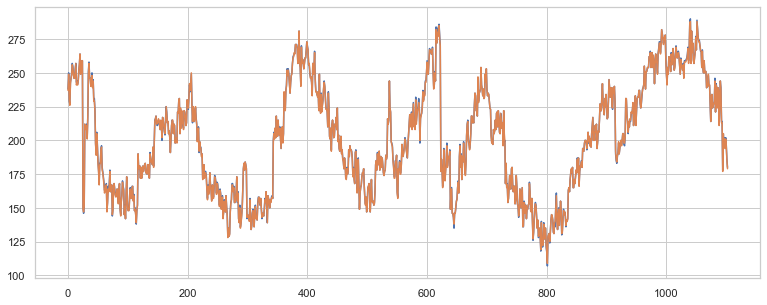

In [50]:
# Preparo las predicciones sobre los datos de training para graficar
#trainPredictPlot = np.empty_like(original[1:1107,4])
#trainPredictPlot[:, :] = np.nan
#trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict[:,4]

# Preparo las predicciones sobre los datos de test para graficar
#testPredictPlot = np.empty_like(dataset)
#testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(2)+1:len(dataset)-1, :] = testPredict

# Grafico
plt.figure(figsize=(13, 5))
plt.plot(original[4:1107,4])
plt.plot(trainPredict[:,4])
#plt.plot(testPredict[:,4])
plt.show()


In [ ]:
# Grafico
plt.figure(figsize=(13, 5))
plt.plot(original[1112:,4])
plt.plot(testPredict[:,4])
plt.show()